Este es un proyecto de reconocimiento de imágenes mediante el uso de una red neuronal convolusional o CNN que mediante la captura de imágenes con una webcam puede realizar una clasificación. A tal fin, creo un set con fotos de tornillos y tarugos plásticos (para fijación en muros). Luego se hace un preprocesado de las imágenes, se arma la estructura de la CNN y se entrena para su posterior prueba clasificando. El set de imágenes se deja en el repositorio así, aquel que desee probar su funcionamiento, pueda hacerlo sin problemas.

In [1]:
# Importamos las librerías necesarias:
from __future__ import absolute_import, division, print_function, unicode_literals

variable_name = ""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import sys
import zipfile
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import math
import os
import io
import errno
import shutil
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

!pip install opencv-python
from google.colab.patches import cv2_imshow
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.layers import  Convolution2D, Activation
from tensorflow.python.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.models import load_model
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,  mean_squared_error, r2_score, plot_confusion_matrix

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [2]:
# Subimos el archivo .Zip con las imágenes:
from google.colab import files
upfiles = files.upload()

Saving SET_CNN.zip to SET_CNN.zip


In [3]:
# Descomprimimos el archivo:
data = zipfile.ZipFile(io.BytesIO(upfiles['SET_CNN.zip']),'r')
data.extractall()

# Creamos una lista con las imágenes de la carpeta "tornillos" (si queremos podemos
# convertir las imágenes a escala de grises), reescalamos el tamaño de las mismas
# y la transformamos en un array de numpy:
path_tor = '/content/tornillos/'
list_tor = []
size_tor = 150

for Tornis in os.listdir(path_tor):
  Tornis = cv2.imread(os.path.join(path_tor,Tornis))
  resize_Tornis = cv2.resize(Tornis,(size_tor,size_tor))
  list_tor.append(resize_Tornis)

# Si quisieramos pasar las imágenes a escala de grises, usamos este otro ciclo for:
#for Tornis in os.listdir(path_tor):
#  Tornis = cv2.imread(os.path.join(path_tor,Tornis))
#  gray_Tornis = cv2.cvtColor(Tornis,cv2.COLOR_BGR2GRAY)
#  gray_resize_Tornis =cv2.resize(gray_Tornis,(tor_size,tor_size))
#  list_tor.append(gray_resize_Tornis)

list_tor = np.array(list_tor)

# Vemos como quedó:
print("Tamaño lista Tornillos:",len(list_tor))
print(list_tor.shape)



Tamaño lista Tornillos: 90
(90, 150, 150, 3)


In [4]:
# Creamos una lista con las imágenes de la carpeta "tarugos" (si queremos podemos
# convertir las imágenes a escala de grises), reescalamos el tamaño de las mismas
# y la transformamos en un array de numpy:
path_tar = '/content/tarugos/'
list_tar = []
size_tar = 150

for Tarug in os.listdir(path_tar):
  Tarug = cv2.imread(os.path.join(path_tar,Tarug))
  resize_Tarug = cv2.resize(Tarug,(size_tar,size_tar))
  list_tar.append(resize_Tarug)

# Si quisieramos pasar las imágenes a escala de grises, usamos este otro ciclo for:
#for Tarug in os.listdir(path_tar):
#  Tarug = cv2.imread(os.path.join(path_tar,Tarug))
#  gray_Tarug = cv2.cvtColor(Tarug,cv2.COLOR_BGR2GRAY)
#  gray_resize_Tarug =cv2.resize(gray_Tarug,(tar_size,tar_size))
#  list_tar.append(gray_resize_Tarug)

list_tar = np.array(list_tar)

# Vemos como quedó:
print("Tamaño lista Tarugos:",len(list_tar))
print(list_tar.shape)

Tamaño lista Tarugos: 90
(90, 150, 150, 3)


In [8]:
# Unimos ambos conjuntos de imágenes:
dataImg = np.concatenate([list_tor,list_tar])
print(len(dataImg))
print(dataImg.shape)

180
(180, 150, 150, 3)


90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
180
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(180,)


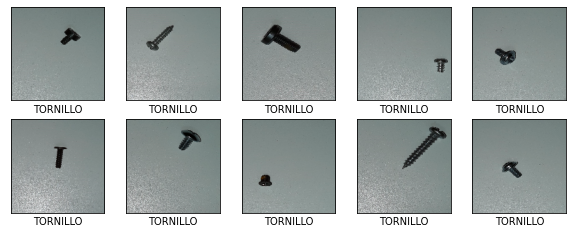

In [9]:
# Creamos la etiqueta "TORNILLO" para las imágenes de tornillos:
label_tor = np.repeat(0,90)
print(len(label_tor))
print(label_tor)

# Creamos la etiqueta "TARUGO" para las imágenes de tarugos:
label_tar = np.repeat(1,90)
print(len(label_tar))
print(label_tar)

# Definimos las clases:
class_names = ['TORNILLO','TARUGO']

# Teniendo en cuenta el orden de las etiquetas, las unimos:
labels = np.concatenate([label_tor,label_tar])
print(len(labels))
print(labels)

# Convertimos "labels" en un array:
Labels = np.array(labels)
print(Labels.shape)

# Comprobamos con algunas imágenes que éstas ya tienen sus respectivas etiquetas:
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(dataImg[i])
  cmap = plt.cm.binary
  plt.xlabel(class_names[Labels[i]])
plt.show()

In [10]:
df_tor = pd.DataFrame(list_tor, label_tor)
df_tar = pd.DataFrame(list_tar, label_tar)
df_tor
df_tar

ValueError: ignored

In [11]:
# Separamos el set en conjuntos de entrenamiento y testeo:
X_train, X_test, y_train, y_test = train_test_split(dataImg, Labels, test_size=0.3, random_state=60)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(126, 150, 150, 3)
(54, 150, 150, 3)
(126,)
(54,)


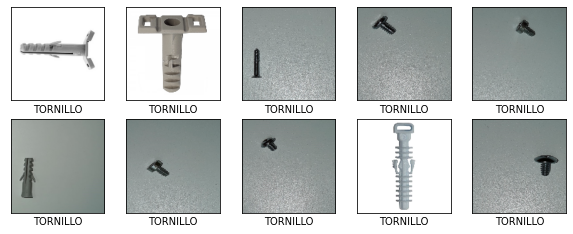

In [12]:
# Comprobamos con algunas imágenes que éstas ya tienen sus respectivas etiquetas:
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i])
  cmap = plt.cm.binary
  plt.xlabel(class_names[Labels[i]])
plt.show()

In [ ]:
# Creamos el modelo de red neuronal convolusional:
# Capa de Entrada:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(180, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 1:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 2:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 3:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 4:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 5:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta 6:
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(720, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Oculta (Flatten):
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(180))
cnn.add(tf.keras.layers.Activation('relu'))
cnn.add(tf.keras.layers.Dropout(0.3))

# Capa Densa de Salida:
cnn.add(tf.keras.layers.Dense(2))
cnn.add(tf.keras.layers.Activation('softmax'))

# Compilamos el modelo:
cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Cargamos la extensión TensorBoard:
%load_ext tensorboard

# Borramos cualquier log de ejecuciones previas:
%rm -rf ./logs/

# Colocamos los registros en un subdirectorio con marca de tiempo:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenamos nuestro modelo:
TrainCnn = cnn.fit(X_train, y_train, batch_size=9, epochs=10, verbose=1, callbacks=[tensorboard_callback])

In [ ]:
# Iniciamos Tensorboard:
%tensorboard --logdir logs/fit

In [ ]:
# También podemos ver el resultado de la función de pérdida en cada época asi:
plt.xlabel("# Epoch")
plt.ylabel("Magnitud de Pérdida")
plt.plot(TrainCnn.history["loss"])

In [ ]:
# Exportamos del modelo en archivos h5. Así guardamos los pesos, los sesgos de la
# red y el estado del optimizador para utlizarlo más adelante o en otro proyecto:
# Recordad descargar los archivos a su equipo para volver a subirlos después, ya
# que al finalizar la sesión de Colab estos se perderán.
cnn.save('modelo_cnn.h5')
cnn.save_weights('pesos_cnn.h5')

In [ ]:
#--------------------------------- ATENCION ----------------------------------#
# De ser necesario, acá podemos volver a montar la CNN con los valores del modelo
# y los pesos que habíamos exportado. Así, podemos hacer uso de la red neuronal 
# sin necesidad de volver a entrenarla:
modelo = '/content/modelo_cnn.h5'
pesos_modelo = '/content/pesos_cnn.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

In [ ]:
# Utilizando éste código de Javascript, tomamos control de la webcam y sacamos una foto:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Cambiamos el tamaño de la salida para que se ajuste al elemento de video:
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Queda esperando a que se haga Clic en Capturar.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#------------------------------------------------------------------------------#

from IPython.display import Image
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))
  
  # Mostramos la imagen que acabamos de tomar:
  #display(Image(filename))
except Exception as err:
  # Se arrojarán errores si el usuario no tiene cámara web o no tiene los
  # permisos necesarios para acceder a ella.
  print(str(err))

# Declaramos la ruta de origen del archivo de imágen:
source = '/content/photo.jpg'

# Creamos una carpeta llamada 'Cap':
try:
    os.mkdir('Cap')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

#------------------------------------------------------------------------------#

# Declaramos la ruta de destino del archivo de imágen:
destination = '/content/Cap/photo.jpg'
  
# Movemos el archivo:
shutil.move(source,destination)

# Podriíamos también copiarlo, de ser necesario:
#shutil.copyfile(source,destination)

# Creamos una lista con la imágen de la carpeta "Cap", reescalamos el tamaño de
# la misma y la transformamos en un array de numpy:
path_pho = '/content/Cap/'
list_pho = []
size_pho = 150

for Photo in os.listdir(path_pho):
  Photo = cv2.imread(os.path.join(path_pho,Photo))
  resize_Photo = cv2.resize(Photo,(size_pho,size_pho))
  list_pho.append(resize_Photo)

list_pho = np.array(list_pho)

# Ahora tomo la imágen capturada por la cámara y vemos su clasificación:
imgP = list_pho[0]
print(imgP.shape)
imgP = (np.expand_dims(imgP,0))
print(imgP.shape)

plt.figure()
plt.imshow(list_pho[0])
plt.colorbar()
plt.grid(False)
plt.show()

Predic = cnn.predict(imgP)
print(Predic)
#print(np.sum(Predic))
print(np.argmax(Predic))
print("Esta imágen corresponde a un", class_names[np.argmax(Predic)])

# Borramos la imágen a clasificar y la carpeta 'Cap'para volver a utilizar:
os.remove('/content/Cap/photo.jpg')
os.rmdir('/content/Cap')